# Variable Drag Model Visualization

This notebook visualizes the transonic drag rise model implemented in the C++ projectile simulation (`variable_drag_deriv` function).

## 1. Import Libraries

In [26]:
import numpy as np
import matplotlib.pyplot as plt

## 2. Define Physics Logic

We recreate the logic exactly as it appears in `src/derivative_functions.cpp`:
- **Subsonic ($M < 0.8$):** Multiplier = 1.0 (Base Drag)
- **Transonic Rise ($0.8 \le M < 1.0$):** Linear increase from 1.0x to 2.5x
- **Supersonic Decay ($1.0 \le M < 2.0$):** Linear decrease from 2.5x to 1.0x
- **High Supersonic ($M \ge 2.0$):** Multiplier = 1.0 (Base Drag)

In [27]:
def calculate_drag_multiplier(mach):
    """
    Calculates the drag multiplier based on Mach number.
    Replicates the logic from variable_drag_deriv in C++.
    """
    if mach < 0.8:
        return 1.0
    elif 0.8 <= mach < 1.0:
        # Linear rise: (mach - 0.8) / 0.2 gives 0..1 fraction
        # 1.0 + fraction * 1.5 -> ranges from 1.0 to 2.5
        return 1.0 + ((mach - 0.8) / 0.2) * 1.5
    elif 1.0 <= mach < 2.0:
        # Linear decay: (mach - 1.0) / 1.0 gives 0..1 fraction
        # 2.5 - fraction * 1.5 -> ranges from 2.5 down to 1.0
        return 2.5 - ((mach - 1.0) / 1.0) * 1.5
    else: # mach >= 2.0
        return 1.0

# Vectorize the function so it works on numpy arrays
get_drag_multipliers = np.vectorize(calculate_drag_multiplier)

## 3. Generate Data and Plot

We will plot the multiplier over a Mach range of 0.0 to 3.0.

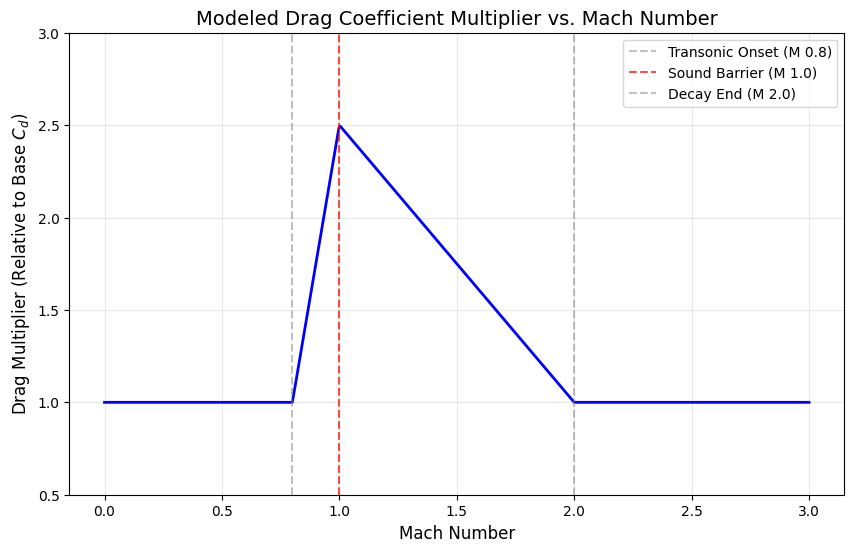

In [28]:
# Generate Mach numbers
mach_numbers = np.linspace(0.0, 3.0, 500)

# Calculate multipliers
multipliers = get_drag_multipliers(mach_numbers)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(mach_numbers, multipliers, linewidth=2, color='blue')

# Highlight key regions
plt.axvline(x=0.8, color='gray', linestyle='--', alpha=0.5, label='Transonic Onset (M 0.8)')
plt.axvline(x=1.0, color='red', linestyle='--', alpha=0.7, label='Sound Barrier (M 1.0)')
plt.axvline(x=2.0, color='gray', linestyle='--', alpha=0.5, label='Decay End (M 2.0)')

# Labels and Title
plt.title('Modeled Drag Coefficient Multiplier vs. Mach Number', fontsize=14)
plt.xlabel('Mach Number', fontsize=12)
plt.ylabel('Drag Multiplier (Relative to Base $C_d$)', fontsize=12)

plt.grid(True, alpha=0.3)
plt.legend()
plt.ylim(0.5, 3.0)

plt.show()

## Program Output & Physics Analysis

Below are the results from the C++ simulation comparing constant drag vs. variable (transonic) drag for a .223 Remington projectile.

```text
Variable Drag Model Evaluation (.223 Remington)
--------------------------------------------------------
Initial Velocity: 975 m/s (Mach 2.8426)
Base k/m: 0.0012
Time step: 0.0010 s
--------------------------------------------------------

Model 0: Vacuum (Theoretical Baseline)
  Optimal Angle: 44.9999 degrees
  Max Distance:  96903.67 m

Model 1: Standard v^2 Drag (Constant Coeff)
  Optimal Angle: 24.7662 degrees
  Max Distance:  2481.73 m

Model 2: Variable Drag (Transonic Rise)
  Optimal Angle: 26.3674 degrees
  Max Distance:  2162.62 m

Impact Analysis:
  Range Reduction: 319.10 m (12.86% loss)
  Angle Shift:     1.60 degrees
```

### Analysis: Why does higher transonic drag result in a higher launch angle?

The result (Angle Shift +1.60°) is fascinating because it contradicts the standard intuition that "More Drag = Lower Optimal Angle".

This phenomenon highlights the difference between **Continuous Energy Loss** (standard model) and **Discrete Energy Barriers** (transonic rise). The variable model introduces a specific **"Event"**—a massive drag spike as between Mach 2.0 and Mach 0.8.

Here is the physics breakdown:

#### 1. The "Kinetic Crash"
The projectile launches at Mach 2.8.
*   **Supersonic Phase (Mach 2.8 → 2.0)**: Low drag. Both models act similarly.
*   **Transonic Wall (Mach 2.0 → 0.8)**: The variable model multiplies drag by up to **2.5x**. This acts like a "brake," rapidly destroying Kinetic Energy ($KE$).

#### 2. Strategy A: Flat Trajectory (Standard Logic)
If you launch at a lower angle (~24°), you prioritize horizontal speed ($v_x$). You cover ground quickly. However, when you hit the "Transonic Wall," that massive drag spike eats your velocity.
*   **Outcome**: You emerge from the transonic phase **low and slow**. Since you are close to the ground, you hit the dirt shortly after slowing down.

#### 3. Strategy B: Steep Trajectory (Why it wins here)
If you launch at a higher angle (~26°), you invest more initial `KE` into **Height (Potential Energy)** rather than immediate distance.
*   **The Benefit**: When the "Transonic Wall" hits and eats your velocity, you still have the **Altitude** you purchased earlier.
*   **Subsonic Glide**: After braking below Mach 0.8, drag drops back to normal levels. Because you are higher up, you can "coast" or trade that potential energy back into horizontal distance during the final low-drag subsonic phase.

#### Summary
The variable drag model forces the projectile to **"bank" energy as altitude** to survive the drag spike. A flatter launch leaves you with no energy (neither speed nor height) once you cross the drag barrier.